In [1]:
import pywatershed
import pandas as pd
import pathlib as pl
import numpy as np
import sys
sys.path.append('../scripts/')
from pest_utils import pars_to_tpl_entries
sys.path.append('../dependencies/')
import pyemu
interrupt_notebook = False

/Users/mnfienen/Documents/GIT/hytest/NHM_CAL/nhm_pestpp/notebooks/../dependencies/pyemu/pst/pst_handler.py:15: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


In [2]:
all_models = ['01473000','05431486','09112500','14015000']# Create a list of all cutouts

In [3]:
rootdir = pl.Path('../NHM_extractions/20230110_pois_haj/')# Path to location of cutouts

In [4]:
cm = all_models[0] # sets cutout from list
pestdir = rootdir/ cm # stes path to location of NHM output folder where output files are.

In [5]:
pst = pyemu.Pst(str(pestdir / 'prior_mc_loc.pst'))

error parsing metadata from 'obsnme', continuing


<Axes: >

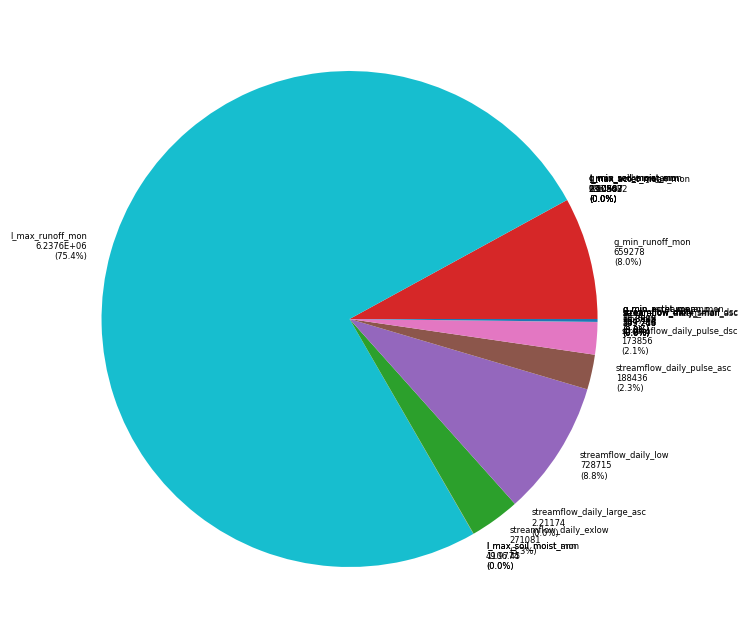

In [6]:
pst.plot(kind='phi_pie')

In [7]:
pst.phi_components

{'g_min_actet_mean_mon': 1.5881916072235507,
 'g_min_actet_mon': 26.308768161701455,
 'g_min_recharge_ann': 61.36047210067078,
 'g_min_runoff_mon': 659278.4794840568,
 'g_min_sca_daily': 0.0,
 'g_min_soil_moist_ann': 89.45965595183674,
 'g_min_soil_moist_mon': 236.94038857346325,
 'l_max_actet_mean_mon': 0.10862205730500371,
 'l_max_actet_mon': 2.5056653759706444,
 'l_max_recharge_ann': 9.003076241704727,
 'l_max_runoff_mon': 6237598.586234627,
 'l_max_sca_daily': 0.0,
 'l_max_soil_moist_ann': 49.97738315061821,
 'l_max_soil_moist_mon': 1106.4504541904855,
 'streamflow_daily_exlow': 271081.43545718776,
 'streamflow_daily_large_asc': 2.211740858638125,
 'streamflow_daily_low': 728714.7233065579,
 'streamflow_daily_pulse_asc': 188435.61616867472,
 'streamflow_daily_pulse_dsc': 173855.56071822825,
 'streamflow_daily_small_asc': 409.24897029681705,
 'streamflow_daily_small_dsc': 243.21636783214322,
 'streamflow_mean_mon': 597.7041815444596,
 'streamflow_mon': 15479.406845128055}

#### read in the zero-weighthing information

In [8]:
zw_df = pd.read_csv('../Supporting_information/zero_weighting.csv', dtype={'cutout':str,'location':str})

In [9]:
if isinstance(zw_df,pd.Series):
    zw_df = zw_df.to_frame().T
zw_df

,cutout,group,location,stmonth,endmonth
0,01473000,streamflow,01472620,1,12
1,05431486,streamflow,05431022,7,12


In [10]:
zw_df = zw_df.loc[zw_df.cutout==cm]

In [11]:
# for now, just zero out entire gages
# TODO: andle sub-annual, month by month changes
obs = pst.observation_data
for cloc in zw_df.loc[zw_df.cutout==cm,'location']:
    obs.loc[obs.obsnme.str.contains(cloc),'weight'] = 0
obs

,obsnme,obsval,weight,obgnme,lower_bound,upper_bound,standard_deviation
obsnme,,,,,,,
g_min_actet_mean_mon:10:5621,g_min_actet_mean_mon:10:5621,0.026491,5.000000,g_min_actet_mean_mon,0,1.000000e+11,0.000026
g_min_actet_mean_mon:10:5625,g_min_actet_mean_mon:10:5625,0.035218,5.000000,g_min_actet_mean_mon,0,1.000000e+11,0.000035
g_min_actet_mean_mon:10:5628,g_min_actet_mean_mon:10:5628,0.027255,5.000000,g_min_actet_mean_mon,0,1.000000e+11,0.000027
g_min_actet_mean_mon:10:5635,g_min_actet_mean_mon:10:5635,0.036991,5.000000,g_min_actet_mean_mon,0,1.000000e+11,0.000037
g_min_actet_mean_mon:10:5637,g_min_actet_mean_mon:10:5637,0.034755,5.000000,g_min_actet_mean_mon,0,1.000000e+11,0.000035
...,...,...,...,...,...,...,...
streamflow_mon:2010_9:01472198,streamflow_mon:2010_9:01472198,15.563666,0.642522,streamflow_mon,0,1.000000e+11,1.556367
streamflow_mon:2010_9:01472199,streamflow_mon:2010_9:01472199,10.906666,0.916870,streamflow_mon,0,1.000000e+11,1.090667
streamflow_mon:2010_9:01472620,streamflow_mon:2010_9:01472620,36.813332,0.000000,streamflow_mon,0,1.000000e+11,3.681333


In [12]:
zw_df.loc[zw_df.cutout==cm,'location']

0    01472620
Name: location, dtype: object

In [13]:
phi = pst.phi
phi

7982547.815258233

In [14]:
#stop

In [15]:
phi_new_comps = {'l_max_actet_mean_mon':0.05 * phi,
                 'g_min_actet_mean_mon':0.05 * phi,
                 'l_max_actet_mon':  .05 * phi,
                 'g_min_actet_mon':  .05 * phi,
                 'streamflow_nodata': 0 * phi,
                 'l_max_recharge_ann': 0.05 * phi,
                 'g_min_recharge_ann': 0.05 * phi,
                 'l_max_runoff_mon': .075 * phi,
                 'g_min_runoff_mon': .075 * phi,
                 'l_max_sca_daily':0 * phi,
                 'g_min_sca_daily':0 * phi,
                 'l_max_soil_moist_ann': 0.05 * phi,
                 'g_min_soil_moist_ann': 0.05 * phi,
                 'l_max_soil_moist_mon': 0.05 * phi,
                 'g_min_soil_moist_mon': 0.05 * phi,
                 'streamflow_mean_mon': .10 * phi,
                 'streamflow_mon': .15 * phi }

In [16]:
# add streamflow_daily components

#Changed above to '0' for now, rebalance above accordingly
stream_comps_perc = 0.10 
stream_comps = len([i for i,_ in pst.phi_components.items() if i.lower().startswith('streamflow_daily')])
stream_comps_each_perc = stream_comps_perc / stream_comps

for i in pst.phi_components.keys():
    if i.lower().startswith('streamflow_daily'):
        phi_new_comps[i] = stream_comps_each_perc * phi

In [17]:
try:
    assert np.isclose(sum([i for _,i in phi_new_comps.items()])/phi, 1.0)
    print('Very very close to 1.0. Carry on!')
except:
    print('Not close to 1.0. Stop and recheck your weight for catagory.')

Very very close to 1.0. Carry on!


In [18]:
sum([i for _,i in phi_new_comps.items()])/phi

0.9999999999999998

In [19]:
assert np.isclose(sum([i for _,i in phi_new_comps.items()])/phi, 1.0)

In [20]:
pst.obs_groups

['g_min_actet_mean_mon',
 'g_min_actet_mon',
 'g_min_recharge_ann',
 'g_min_runoff_mon',
 'g_min_sca_daily',
 'g_min_soil_moist_ann',
 'g_min_soil_moist_mon',
 'l_max_actet_mean_mon',
 'l_max_actet_mon',
 'l_max_recharge_ann',
 'l_max_runoff_mon',
 'l_max_sca_daily',
 'l_max_soil_moist_ann',
 'l_max_soil_moist_mon',
 'streamflow_daily_large_asc',
 'streamflow_daily_small_asc',
 'streamflow_daily_small_dsc',
 'streamflow_daily_pulse_asc',
 'streamflow_daily_pulse_dsc',
 'streamflow_daily_low',
 'streamflow_daily_exlow',
 'streamflow_mean_mon',
 'streamflow_mon']

In [21]:
pst.adjust_weights(obsgrp_dict=phi_new_comps)

<Axes: >

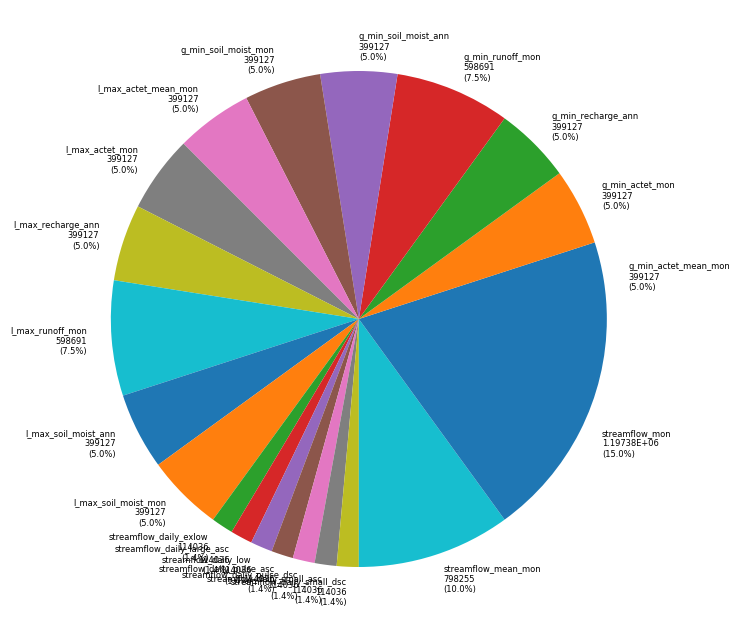

In [22]:
pst.plot(kind='phi_pie')

In [23]:
pst.observation_data.loc[pst.observation_data.obgnme=='streamflow_nodata']

,obsnme,obsval,weight,obgnme,lower_bound,upper_bound,standard_deviation
obsnme,,,,,,,


In [24]:
#Write a new version of the PEST++ control file (.pst)
pst.control_data.noptmax=-1
pst.write(str(rootdir/cm/ 'prior_mc_reweight.pst'), version=2)


noptmax:-1, npar_adj:2339, nnz_obs:46534


In [25]:
print(pst.adjust_weights(obsgrp_dict=phi_new_comps))


None


In [26]:
#Write this to a dataframe (.csv) and save it somewhere so that we have a record of it. with time date and append to .csv every notebook run.
print(pst.phi_components_normalized)


{'g_min_actet_mean_mon': 0.05000000000000001, 'g_min_actet_mon': 0.050000000000000024, 'g_min_recharge_ann': 0.050000000000000024, 'g_min_runoff_mon': 0.07500000000000004, 'g_min_sca_daily': 0.0, 'g_min_soil_moist_ann': 0.050000000000000024, 'g_min_soil_moist_mon': 0.050000000000000024, 'l_max_actet_mean_mon': 0.05000000000000002, 'l_max_actet_mon': 0.05000000000000002, 'l_max_recharge_ann': 0.05000000000000001, 'l_max_runoff_mon': 0.07500000000000005, 'l_max_sca_daily': 0.0, 'l_max_soil_moist_ann': 0.05000000000000002, 'l_max_soil_moist_mon': 0.050000000000000024, 'streamflow_daily_exlow': 0.01428571428571429, 'streamflow_daily_large_asc': 0.01428571428571429, 'streamflow_daily_low': 0.014285714285714292, 'streamflow_daily_pulse_asc': 0.014285714285714292, 'streamflow_daily_pulse_dsc': 0.014285714285714292, 'streamflow_daily_small_asc': 0.014285714285714292, 'streamflow_daily_small_dsc': 0.01428571428571429, 'streamflow_mean_mon': 0.10000000000000003, 'streamflow_mon': 0.1500000000000

### update the localization matrix to remove groups with only 0-weighted obs

In [27]:
# find zero-weighted groups
zero_grps = list(set(pst.obs_groups) - set(pst.nnz_obs_groups))
zero_grps

['g_min_sca_daily', 'l_max_sca_daily']

In [28]:
# read in the localization matrix from the run directory
locmat = pyemu.Matrix.from_ascii(str(rootdir / cm / 'loc.mat')).to_dataframe()

In [29]:
# confirm that we can select only the rows that are not in the zero-weighted groups lines
locmat.loc[~locmat.index.isin(zero_grps)]

,obs_combo_1,obs_combo_2,obs_combo_3,obs_combo_4,obs_combo_5,obs_combo_6,obs_combo_7
g_min_actet_mean_mon,1.0,0.0,1.0,1.0,1.0,0.0,1.0
g_min_actet_mon,1.0,0.0,1.0,1.0,1.0,0.0,1.0
g_min_recharge_ann,1.0,0.0,1.0,1.0,1.0,0.0,1.0
g_min_runoff_mon,1.0,0.0,1.0,1.0,1.0,0.0,1.0
g_min_soil_moist_ann,1.0,0.0,1.0,1.0,1.0,0.0,1.0
g_min_soil_moist_mon,1.0,0.0,1.0,1.0,1.0,0.0,1.0
l_max_actet_mean_mon,1.0,0.0,1.0,1.0,1.0,0.0,1.0
l_max_actet_mon,1.0,0.0,1.0,1.0,1.0,0.0,1.0
l_max_recharge_ann,1.0,0.0,1.0,1.0,1.0,0.0,1.0
l_max_runoff_mon,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [30]:
len(locmat),len(locmat.loc[~locmat.index.isin(zero_grps)])

(21, 21)

In [31]:
# write out the new matrix in PEST style
pyemu.Matrix.from_dataframe(locmat.loc[~locmat.index.isin(zero_grps)]).to_ascii(str(rootdir/cm/ 'loc.mat'))